In [ ]:
# @title
!pip install -U -q transformers datasets accelerate huggingface_hub pyquery xgboost

In [2]:
import pandas as pd
import numpy as np
import huggingface_hub
from tqdm.auto import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from datasets import Dataset
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import (AutoTokenizer, pipeline, AutoModelForSequenceClassification, TrainingArguments,
                          Trainer, DataCollatorWithPadding)
from sklearn.metrics import (accuracy_score, recall_score, precision_score, log_loss, roc_auc_score,
                             roc_curve, precision_recall_curve)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC
from keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, TextVectorization

# **PHISHING CLASSIFIERS COMPARATIVE** 📈

This notebook is dedicated to run a performance comparison on phishing classification between traditional ML models and the [BERT language model finetuned for phishing detection](https://huggingface.co/ealvaradob/bert-finetuned-phishing). It is assumed that, considering the bidirectional architecture, its masked language-based pre-training and fine tuning, BERT FINETUNED should be able to outperform traditional models thanks to a deep analysis of the malicious language used in phishing messages, URLs or website code. And it is safe to say that BERT FINETUNED is better suited for phishing detection than pre-trained base BERT, as the latter has not been trained for this particular type of task.

The models that will be discussed in this notebook are as follows:

- XGBoost ✅
- Multinomial Naive Bayes ✅
- LSTM-CNN Neural Network ✅
- Pre-trained base BERT ✅
- BERT finetuned for phishing detection ✅

In [3]:
colors = ['orange', 'gold', 'mediumturquoise', 'lightblue', 'midnightblue']

The performance evaluation will be performed in four separate sets:
- Texts (SMS and Emails)
- URLs
- Websites
- [Phishing dataset](https://huggingface.co/datasets/ealvaradob/phishing-dataset) combining all the above sets.

## **Phishing Datasets**

Importing the URL, HTML, text and combined dataset that have been preprocessed beforehand

In [6]:
huggingface_hub.login()

In [4]:
texts = pd.read_csv('TEXTS.csv')
urls = pd.read_csv('URLS.csv')
webs = pd.read_csv('WEBS.csv')
train_combined, test_combined = pd.read_json('train.json'), pd.read_json('test.json') # combined dataset

We will only keep 5% of the urls samples because that is how is constructed the combined phishing dataset

In [5]:
urls, _ = train_test_split(urls, test_size=0.95, stratify=urls['label'], random_state=42)

Splitting in train-test sets ...

In [6]:
def split_dataset(df):
  return train_test_split(
    df['text'],
    df['label'],
    stratify=df['label'],
    test_size=0.2,
    random_state=42
  )

In [7]:
xtrain_text, xtest_text, ytrain_text, ytest_text = split_dataset(texts)
xtrain_url, xtest_url, ytrain_url, ytest_url = split_dataset(urls)
xtrain_web, xtest_web, ytrain_web, ytest_web = split_dataset(webs)
xtrain_comb, xtest_comb, ytrain_comb, ytest_comb = train_combined['text'], test_combined['text'], train_combined['label'], test_combined['label']

## **Vectorizing data with TF-IDF**

Most machine learning algorithms are fulfilled with mathematical things such as statistics, algebra, calculus and etc. They expect the data to be numerical such as a 2-dimensional array with rows as instances and columns as features. The problem with natural language is that the data is in the form of raw text, so that the text needs to be transformed into a vector. The process of transforming text into a vector is commonly referred to as text vectorization. It’s a fundamental process in natural language processing because none of the machine learning algorithms understand a text, not even computers. Text vectorization algorithm namely TF-IDF vectorizer, which is a very popular approach for traditional machine learning algorithms can help in transforming text into vectors.

https://towardsdatascience.com/tf-idf-simplified-aba19d5f5530

In [8]:
MAX_WORDS_NUM = 50000
N_GRAMS = (1, 2)

def vectorize_dataset(train, test):
  # Create TF-IDF Vectorizer
  tfidf_vect = TfidfVectorizer(ngram_range=N_GRAMS, max_df=0.25, stop_words='english', max_features=MAX_WORDS_NUM)
  # Fit TF-IDF Vectorizer on train
  train_vect = tfidf_vect.fit_transform(train)
  # Transform
  test_vect = tfidf_vect.transform(test)
  return train_vect, test_vect

In [9]:
xtrain_text_vect, xtest_text_vect = vectorize_dataset(xtrain_text, xtest_text)
xtrain_url_vect, xtest_url_vect = vectorize_dataset(xtrain_url, xtest_url)
xtrain_web_vect, xtest_web_vect = vectorize_dataset(xtrain_web, xtest_web)
xtrain_comb_vect, xtest_comb_vect = vectorize_dataset(xtrain_comb, xtest_comb)

## **Model's Definitions**

### XGBoost

XGBoost (Extreme Gradient Boosting) is a gradient
boosting algorithm based on decision tree method for
classification and regression. XGBoost which is based on
Gradient Boosting (GB) technique, uses, a technique to
“boost” or “improve” a week learner by combining it with
other week learners to generate an improved predictive
model. In GB, trees are built sequentially whereas XGBoost,
builds trees parallelly making it more scalable with more
computational speed. It employs a level-wise approach,
scanning over gradient values and assessing the quality of
splits at each potential split in the training set using these
partial sums. It can handle various types of data and problems, including phishing classification. XGBoost is one of the most powerful available classifiers, made famous by its long string of Kaggle competitions wins.

> Sadaf, Kishwar. (2023). Phishing Website Detection using XGBoost and Catboost Classifiers. 1-6. 10.1109/ICSCA57840.2023.10087829.

In [10]:
xgb = XGBClassifier(
    colsample_bytree = 0.7,
    gamma = 0.2,
    learning_rate = 0.1,
    max_depth = 12,
    min_child_weight = 2,
    n_estimators = 100,
    subsample = 0.8,
    objective = 'binary:logistic'
)

### Multinomial Naive Bayes (MNB)

The Naive Bayes method is very well-known method for
text classification due to its effective grating assumptions, quick and easy implantation. The classifiers of Naive Bayes (NB) are a family of classifiers based on bayes' popular probability theorem, known as to create simple powerful models, particularly in the areas of document classification and disease prediction. The textual classification of NB is most often used for categorizing text as it is quick and easy to implement. The less faulty algorithms tend to be slower and more complex.

> Abbas, Muhammad & Ali, Kamran & Memon, Saleem & Jamali, Abdul & Memon, Saleemullah & Ahmed, Anees. (2019). Multinomial Naive Bayes Classification Model for Sentiment Analysis. 10.13140/RG.2.2.30021.40169.

In [11]:
mnb = MultinomialNB(alpha=0.01)

### LSTM-CNN

Recurrent neural networks are different from traditional feed-forward neural networks. This difference in the addition of complexity comes with the promise of new behaviors that the traditional methods cannot achieve. Recurrent networks have an internal state that can represent context information. They keep information about past inputs for an amount of time that is not fixed a priori, but rather depends on its weights and on the input data. It contain cycles that feed the network activations from a previous time step as inputs to the network to influence predictions at the current time step. These activations are stored in the internal states of the network which can in principle hold long-term temporal contextual information. This mechanism allows RNNs to exploit a dynamically changing contextual window over the input sequence history.

Standard RNNs fail to learn in the presence of time lags greater than 5 – 10 discrete time steps between relevant input events and target signals. The vanishing error problem casts doubt on whether standard RNNs can indeed exhibit significant practical advantages over time window-based feedforward networks. **“Long Short-Term Memory” (LSTM)** model is not affected by this problem. LSTM can learn to bridge minimal time lags in excess of 1000 discrete time steps by enforcing constant error flow through “constant error carrousels” (CECs) within special units, called cells.

A **Convolutional neural network (CNN)** is a discriminative architecture that works effectively at processing grid-based two-dimensional data, including images and videos. In terms of time delay, the CNN outperforms the neural network (NN). The weights are shared in a temporal dimension in the CNN, which reduces calculation time. The standard NN’s generic matrix multiplication is thus replaced in the CNN. As a result, the CNN technique minimizes the weights, lowering the network’s complexity.

**LSTM–CNN** architecture involves both CNN and LSTM methods in order to make use of the benefits of both methods and accomplish excellent performance. Since CNN and LSTM show high performance in overcoming classification, detection, and recognition tasks, to using these three methods for the phishing detection task is promising. The LSTM—CNN model consists of CNN layers that extract features from input data and LSTM layers that predict sequences. Furthermore, a study found that combining a 1D convolution layer and an LSTM layer improves the accuracy of malicious URL identification when compared to models that exclusively use LSTM layers. As a result, when constructing the system, we chose 1D CNN and LSTM architecture to train the phishing dataset.

> Alshingiti, Z., Alaqel, R., Al-Muhtadi, J., Haq, Q. E. U., Saleem, K., & Faheem, M. H. (2023). A Deep Learning-Based Phishing Detection System Using CNN, LSTM, and LSTM-CNN. Electronics, 12(1), 232. https://doi.org/10.3390/electronics12010232


In [12]:
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 10

def compile_lstm_cnn_model(text):

  # Using TF-IDF with LSTM is not a common approach, as LSTM networks are generally more suitable for
  # handling sequential data like text sequences. TF-IDF, on the other hand, is a technique commonly used
  # for converting text data into fixed-length vectors based on the importance of words in a document.
  # That's why we will add a vectorization layer in the model that can create sequences.
  # https://datascience.stackexchange.com/a/124744

  tv = TextVectorization(max_tokens=MAX_WORDS_NUM, output_sequence_length=MAX_SEQUENCE_LENGTH, ngrams=N_GRAMS)
  tv.adapt(text)

  # Create LSTM-CNN model
  lstm_cnn = Sequential()
  lstm_cnn.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  lstm_cnn.add(tv)
  # embedded layer that uses EMBEDDING_DIM length vectors to represent each word.
  lstm_cnn.add(Embedding(MAX_WORDS_NUM, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
  # SpatialDropout1D performs variational dropout in NLP models.
  lstm_cnn.add(SpatialDropout1D(0.2))
  lstm_cnn.add(LSTM(100, return_sequences=True))
  lstm_cnn.add(Conv1D(50, kernel_size=3, activation='relu'))
  lstm_cnn.add(GlobalMaxPooling1D())
  lstm_cnn.add(Dense(32))
  lstm_cnn.add(Dense(2, activation="softmax"))
  # Because it is a binary classification problem, binary_crossentropy is used as the loss function.
  lstm_cnn.compile(
      optimizer=Adam(learning_rate=1e-4),
      loss="binary_crossentropy",
      metrics=['accuracy', Precision(), Recall(), AUC()]
  )

  return lstm_cnn

### BERT

BERT is an ML model that has a significant advantage over other popular language models on the market. As explained by its authors (Devlin et al., 2018), standard language models such as ELMo and GPT, have the limitation of being unidirectional, i.e., they can only parse text in one direction: right-to-left or left-to-right. In the case of GPT, the authors employ a left-right architecture that can only see what is before each piece of text, but not what is after. Such a restriction could be detrimental to the Finetuning of a model that one wishes to specialize for NLP tasks such as question answering or, in this case, phishing classification, where deep language understanding is needed by analyzing the entire context of the sample. Thus, Devlin et al. (2018) improves on the Finetuning approach for NLP tasks by proposing BERT, whose English abbreviation translates to: Bidirectional Encoding Representations from Transformers. BERT alleviates the unidirectionality constraint by masking or randomly hiding some of the text chunks that are entered into the model during pre-training, with the goal of trying to predict the original hidden chunk by checking the surrounding context. This pre-training tactic categorizes BERT as a masked language model (MLM), which gives it the ability to learn a much richer and deeper language compared to other models.

> Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

In [13]:
# retrieving BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

# mapping the expected ids to their labels
id2label = {0: "benign", 1: "phishing"}
label2id = {"benign": 0, "phishing": 1}

# dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

# bert model
bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# pre-trained bert base classifier
bert_base = pipeline(
    task='text-classification',
    model=bert,
    tokenizer=bert_tokenizer,
    truncation=True,
    device=0
)

In [ ]:
# bert finetuned on phishing detection
bert_finetuned = pipeline(
    model='ealvaradob/bert-finetuned-phishing',
    tokenizer=bert_tokenizer,
    truncation=True,
    device=0
)

config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

## **Training models**

In this section we will train the models on each of the aforementioned datasets, and after the training we'll get the evaluation results based on specific metrics:

- Accuracy
- Precision
- Recall
- AUC

### XGBOOST

In [15]:
def xgboost_results(xtrain, xtest, ytrain, dataset):
  print(f"Training XGBoost on {dataset} dataset ...")
  # training xgboost in text dataset
  xgb.fit(xtrain, ytrain)
  print("\n<--- Finished, returning predictions")
  # predictions
  xgb_pred = xgb.predict(xtest)
  xgb_predproba = xgb.predict_proba(xtest)[:, 1]
  return [xgb_pred, xgb_predproba]

In [ ]:
%%time
xgb_text_results = xgboost_results(xtrain_text_vect, xtest_text_vect, ytrain_text, 'text')

Training XGBoost on text dataset ...

<--- Finished, returning predictions
CPU times: user 6min 23s, sys: 2.35 s, total: 6min 25s
Wall time: 54.1 s


In [ ]:
%%time
xgb_url_results = xgboost_results(xtrain_url_vect, xtest_url_vect, ytrain_url, 'url')

Training XGBoost on url dataset ...

<--- Finished, returning predictions
CPU times: user 54 s, sys: 401 ms, total: 54.4 s
Wall time: 7.05 s


In [16]:
%%time
xgb_web_results = xgboost_results(xtrain_web_vect, xtest_web_vect, ytrain_web, 'web')

Training XGBoost on web dataset ...

<--- Finished, returning predictions
CPU times: user 19min 26s, sys: 9.97 s, total: 19min 36s
Wall time: 3min 18s


In [ ]:
%%time
xgb_comb_results = xgboost_results(xtrain_comb_vect, xtest_comb_vect, ytrain_comb, 'combined')

Training XGBoost on combined dataset ...

<--- Finished, returning predictions
CPU times: user 26min 28s, sys: 15 s, total: 26min 43s
Wall time: 4min 55s


### MNB

In [17]:
def mnb_results(xtrain, xtest, ytrain, dataset):
  print(f"Training MNB on {dataset} dataset ...")
  # training mnb in text dataset
  mnb.fit(xtrain, ytrain)
  print("\n<--- Finished, returning predictions")
  # predictions
  mnb_pred = mnb.predict(xtest)
  mnb_predproba = mnb.predict_proba(xtest)[:, 1]
  return [mnb_pred, mnb_predproba]

In [ ]:
%%time
mnb_text_results = mnb_results(xtrain_text_vect, xtest_text_vect, ytrain_text, 'text')

Training MNB on text dataset ...

<--- Finished, returning predictions
CPU times: user 30.1 ms, sys: 3 µs, total: 30.1 ms
Wall time: 28.2 ms


In [ ]:
%%time
mnb_url_results = mnb_results(xtrain_url_vect, xtest_url_vect, ytrain_url, 'url')

Training MNB on url dataset ...

<--- Finished, returning predictions
CPU times: user 14.4 ms, sys: 1.98 ms, total: 16.4 ms
Wall time: 15.9 ms


In [18]:
%%time
mnb_web_results = mnb_results(xtrain_web_vect, xtest_web_vect, ytrain_web, 'web')

Training MNB on web dataset ...

<--- Finished, returning predictions
CPU times: user 91.9 ms, sys: 0 ns, total: 91.9 ms
Wall time: 89.5 ms


In [ ]:
%%time
mnb_comb_results = mnb_results(xtrain_comb_vect, xtest_comb_vect, ytrain_comb, 'combined')

Training MNB on combined dataset ...

<--- Finished, returning predictions
CPU times: user 172 ms, sys: 28 µs, total: 172 ms
Wall time: 156 ms


### LSTM-CNN

In [19]:
def lstm_cnn_results(xtrain, xtest, ytrain, dataset, epochs=4, batch_size=32):
  print(f"Training LSTM-CNN on {dataset} dataset ...")
  # training lstm_cnn in text dataset
  nn = compile_lstm_cnn_model(xtrain)
  nn.fit(
      xtrain,
      to_categorical(ytrain, num_classes=2),
      epochs=epochs,
      batch_size=batch_size
  )
  print("\n<--- Finished, returning predictions")
  nn_pred = tf.argmax(nn.predict(xtest), axis=1)
  nn_predproba = nn.predict(xtest)[:, 1]
  return [nn_pred, nn_predproba]

In [ ]:
%%time
nn_text_results = lstm_cnn_results(xtrain_text, xtest_text, ytrain_text, 'text')

Training LSTM-CNN on text dataset ...
Epoch 1/4
504/504 [==============================] - 54s 93ms/step - loss: 0.4924 - accuracy: 0.7383 - precision: 0.7383 - recall: 0.7383 - auc: 0.8276
Epoch 2/4
504/504 [==============================] - 18s 36ms/step - loss: 0.1694 - accuracy: 0.9376 - precision: 0.9376 - recall: 0.9376 - auc: 0.9766
Epoch 3/4
504/504 [==============================] - 12s 25ms/step - loss: 0.1143 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9874
Epoch 4/4
504/504 [==============================] - 10s 20ms/step - loss: 0.0854 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9915

<--- Finished, returning predictions
126/126 [==============================] - 1s 8ms/step
CPU times: user 1min 36s, sys: 6.33 s, total: 1min 43s
Wall time: 1min 50s


In [ ]:
%%time
nn_url_results = lstm_cnn_results(xtrain_url, xtest_url, ytrain_url, 'url', epochs=12)

Training LSTM-CNN on url dataset ...
Epoch 1/12
1030/1030 [==============================] - 18s 10ms/step - loss: 0.6915 - accuracy: 0.5308 - precision: 0.5308 - recall: 0.5308 - auc: 0.5299
Epoch 2/12
1030/1030 [==============================] - 8s 8ms/step - loss: 0.6914 - accuracy: 0.5308 - precision: 0.5308 - recall: 0.5308 - auc: 0.5303
Epoch 3/12
1030/1030 [==============================] - 8s 8ms/step - loss: 0.6892 - accuracy: 0.5319 - precision: 0.5319 - recall: 0.5319 - auc: 0.5618
Epoch 4/12
1030/1030 [==============================] - 8s 8ms/step - loss: 0.6167 - accuracy: 0.6649 - precision: 0.6649 - recall: 0.6649 - auc: 0.7234
Epoch 5/12
1030/1030 [==============================] - 9s 8ms/step - loss: 0.4931 - accuracy: 0.7590 - precision: 0.7590 - recall: 0.7590 - auc: 0.8402
Epoch 6/12
1030/1030 [==============================] - 8s 8ms/step - loss: 0.3923 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - auc: 0.9027
Epoch 7/12
1030/1030 [=====================

In [20]:
%%time
nn_web_results = lstm_cnn_results(xtrain_web, xtest_web, ytrain_web, 'web', epochs=7)

Training LSTM-CNN on web dataset ...
Epoch 1/7
394/394 [==============================] - 65s 148ms/step - loss: 0.5706 - accuracy: 0.6999 - precision: 0.6999 - recall: 0.6999 - auc: 0.7649
Epoch 2/7
394/394 [==============================] - 32s 80ms/step - loss: 0.3209 - accuracy: 0.8679 - precision: 0.8679 - recall: 0.8679 - auc: 0.9346
Epoch 3/7
394/394 [==============================] - 29s 73ms/step - loss: 0.2430 - accuracy: 0.9053 - precision: 0.9053 - recall: 0.9053 - auc: 0.9607
Epoch 4/7
394/394 [==============================] - 27s 67ms/step - loss: 0.2070 - accuracy: 0.9211 - precision: 0.9211 - recall: 0.9211 - auc: 0.9685
Epoch 5/7
394/394 [==============================] - 25s 64ms/step - loss: 0.1795 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9755
Epoch 6/7
394/394 [==============================] - 27s 68ms/step - loss: 0.1599 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9793
Epoch 7/7
394/394 [==============================]

In [ ]:
%%time
nn_comb_results = lstm_cnn_results(xtrain_comb, xtest_comb, ytrain_comb, 'combined', epochs=7)

Training LSTM-CNN on combined dataset ...
Epoch 1/7
1928/1928 [==============================] - 143s 71ms/step - loss: 0.5814 - accuracy: 0.6304 - precision: 0.6304 - recall: 0.6304 - auc: 0.7132
Epoch 2/7
1928/1928 [==============================] - 67s 35ms/step - loss: 0.4706 - accuracy: 0.7058 - precision: 0.7058 - recall: 0.7058 - auc: 0.8145
Epoch 3/7
1928/1928 [==============================] - 61s 32ms/step - loss: 0.4450 - accuracy: 0.7175 - precision: 0.7175 - recall: 0.7175 - auc: 0.8293
Epoch 4/7
1928/1928 [==============================] - 59s 31ms/step - loss: 0.4305 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - auc: 0.8378
Epoch 5/7
1928/1928 [==============================] - 58s 30ms/step - loss: 0.4231 - accuracy: 0.7273 - precision: 0.7273 - recall: 0.7273 - auc: 0.8398
Epoch 6/7
1928/1928 [==============================] - 56s 29ms/step - loss: 0.4142 - accuracy: 0.7319 - precision: 0.7319 - recall: 0.7319 - auc: 0.8460
Epoch 7/7
1928/1928 [============

### BERT

In the case of the pre-trained and finetuned BERT model, no training will be performed, rather only inference on the test sets of the datasets. This is because, first of all, we want to evaluate the performance by BERT base without performing any training, since this model already has a default capability for various NLP tasks. Second, BERT finetuned for phishing detection already went through a training process to precisely classify phishing in the text samples, urls and websites. But in the case of normal BERT, we will train it on each of the different datasets, except the combined one (because BERT finetuned was already trained on it), in order to evaluate its performance.

In [21]:
def get_predict_proba(label, score):
  """
  Get prediction probabilities from the positive class, i.e phishing
  """
  if label == 'benign':
    return 1 - score
  return score

def bert_results(pipe, pipe_name, xtest, dataset):
  print(f"Making inferences on {dataset} dataset by {pipe_name} ...")
  pred, predproba = [], []
  for out in tqdm(pipe(Dataset.from_pandas(xtest.to_frame())['text'])):
    pred.append(label2id[out['label']])
    predproba.append(get_predict_proba(out['label'], out['score']))
  print("\n<--- Finished inference, returning predictions")
  return [pred, predproba]

#### Pre-trained BERT base

In [ ]:
%%time
bert_base_text_results = bert_results(bert_base, 'pre-trained BERT base', xtest_text, 'text')

Making inferences on text dataset by pre-trained BERT base ...


  0%|          | 0/4028 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 4min 18s, sys: 280 ms, total: 4min 18s
Wall time: 4min 17s


In [ ]:
%%time
bert_base_url_results = bert_results(bert_base, 'pre-trained BERT base', xtest_url, 'url')

Making inferences on url dataset by pre-trained BERT base ...


  0%|          | 0/8238 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 2min 40s, sys: 195 ms, total: 2min 41s
Wall time: 2min 40s


In [22]:
%%time
bert_base_web_results = bert_results(bert_base, 'pre-trained BERT base', xtest_web, 'web')

Making inferences on web dataset by pre-trained BERT base ...


  0%|          | 0/3152 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 6min 24s, sys: 786 ms, total: 6min 24s
Wall time: 6min 23s


In [ ]:
%%time
bert_base_comb_results = bert_results(bert_base, 'pre-trained BERT base', xtest_comb, 'combined')

Making inferences on combined dataset by pre-trained BERT base ...


  0%|          | 0/15417 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 14min 10s, sys: 1.23 s, total: 14min 11s
Wall time: 14min 8s


#### BERT for training

In [23]:
import torch

def preprocess_function(example):
    return bert_tokenizer(example['text'], truncation=True)

def trained_bert_results(xtrain, xtest, ytrain, ytest, dataset, epochs=1, learning_rate=2e-5):

  global bert

  x = Dataset.from_pandas(pd.concat([xtrain, ytrain], axis=1).reset_index(drop=True))
  y = Dataset.from_pandas(pd.concat([xtest, ytest], axis=1).reset_index(drop=True))
  x_tokenized = x.map(preprocess_function, batched=True)
  y_tokenized = y.map(preprocess_function, batched=True)

  training_args = TrainingArguments(
      output_dir=f"./bert-finetuned-phishing-{dataset}",
      learning_rate=learning_rate,
      per_device_train_batch_size=4,
      per_device_eval_batch_size=4,
      num_train_epochs=epochs,
      evaluation_strategy='epoch',
      save_strategy='no',
      weight_decay=0.01
  )

  trainer = Trainer(
      model=bert,
      args=training_args,
      train_dataset=x_tokenized,
      eval_dataset=y_tokenized,
      tokenizer=bert_tokenizer,
      data_collator=data_collator
  )

  print(f"Training BERT on {dataset} dataset ...")

  trainer.train()

  # save model
  trainer.save_model(f"./bert-finetuned-phishing-{dataset}")

  # free gpu memory
  del bert, trainer
  torch.cuda.empty_cache()

  print("\n<-- Finished training, performing inference ...")

  bert_trained = pipeline(
      task='text-classification',
      model=f"./bert-finetuned-phishing-{dataset}",
      tokenizer=bert_tokenizer,
      truncation=True,
      device=0
  )

  return bert_results(bert_trained, 'trained BERT', xtest, dataset)

In [ ]:
%%time
bert_trained_text_results = trained_bert_results(xtrain_text, xtest_text, ytrain_text, ytest_text, 'text')

Making inferences on text dataset by trained BERT ...


  0%|          | 0/4028 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 4min 22s, sys: 1.09 s, total: 4min 24s
Wall time: 4min 22s


In [ ]:
%%time
bert_trained_url_results = trained_bert_results(xtrain_url, xtest_url, ytrain_url, ytest_url, 'url')

Map:   0%|          | 0/32951 [00:00<?, ? examples/s]

Map:   0%|          | 0/8238 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training BERT on url dataset ...


Epoch,Training Loss,Validation Loss
1,0.107900,0.121096



<-- Finished training, performing inference ...
Making inferences on url dataset by trained BERT ...


  0%|          | 0/8238 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 36min 22s, sys: 42.4 s, total: 37min 4s
Wall time: 36min 59s


In [24]:
%%time
bert_trained_web_results = trained_bert_results(xtrain_web, xtest_web, ytrain_web, ytest_web, 'web', learning_rate=5e-5)

Map:   0%|          | 0/12604 [00:00<?, ? examples/s]

Map:   0%|          | 0/3152 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training BERT on web dataset ...


Epoch,Training Loss,Validation Loss
1,0.653800,0.654108



<-- Finished training, performing inference ...
Making inferences on web dataset by trained BERT ...


  0%|          | 0/3152 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 1h 10min 43s, sys: 15min 34s, total: 1h 26min 18s
Wall time: 1h 26min 2s


#### BERT finetuned for phishing detection

In [ ]:
%%time
bert_tuned_comb_results = bert_results(bert_finetuned, 'BERT finetuned for phishing detection', xtest_comb, 'combined')

Making inferences on combined dataset by BERT finetuned for phishing detection ...


  0%|          | 0/15417 [00:00<?, ?it/s]


<--- Finished inference, returning predictions
CPU times: user 14min, sys: 796 ms, total: 14min 1s
Wall time: 13min 59s


## **Model's Classification Performance Comparison**

In [25]:
def plot_roc_auc_curve(models_predproba, ytest, results):

  plt.figure()

  for i, model_pred_proba in enumerate(models_predproba):
      fpr, tpr, _ = roc_curve(ytest,  model_pred_proba)
      plt.plot(fpr, tpr, label=f"{results.index.values[i]} AUC={results['auc'][i]:.2f}", color=colors[i])

  plt.plot([0, 1], [0, 1], "k--")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("CURVAS ROC-AUC")
  plt.legend(loc='lower right')
  plt.show()

In [26]:
def plot_pre_rec_curve(models_predproba, ytest, results):

  plt.figure()

  for i, model_pred_proba in enumerate(models_predproba):
      precision, recall, _ = precision_recall_curve(ytest,  model_pred_proba)
      plt.plot(recall, precision, label=f"{results.index.values[i]}", color=colors[i])

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("CURVAS PRECISION-RECALL")
  plt.legend(loc='lower left')
  plt.show()

In [27]:
def metrics_evaluation(models_results, ytest):
  metrics_results = []
  for model_result in models_results:
    metrics_results.append({
        'accuracy': accuracy_score(ytest, model_result[0]),
        'precision': precision_score(ytest, model_result[0]),
        'recall': recall_score(ytest, model_result[0]),
        'auc': roc_auc_score(ytest, model_result[1])
    })
  return metrics_results

### Text Classification

In [ ]:
# text models predictions
models_text_results = [xgb_text_results, mnb_text_results, nn_text_results, bert_base_text_results, bert_trained_text_results]

In [ ]:
text_results = pd.DataFrame(
    metrics_evaluation(models_text_results, ytest_text),
    index = ['XGBoost', 'MNB', 'LSTM-CNN', 'BERT-Base', 'BERT-Finetuned']
)

text_results

,accuracy,precision,recall,auc
XGBoost,0.943148,0.946648,0.901629,0.988147
MNB,0.955313,0.940794,0.942020,0.993090
LSTM-CNN,0.960775,0.975812,0.919870,0.994740
BERT-Base,0.604270,0.466817,0.270358,0.572976
BERT-Finetuned,0.990318,0.990170,0.984365,0.999146


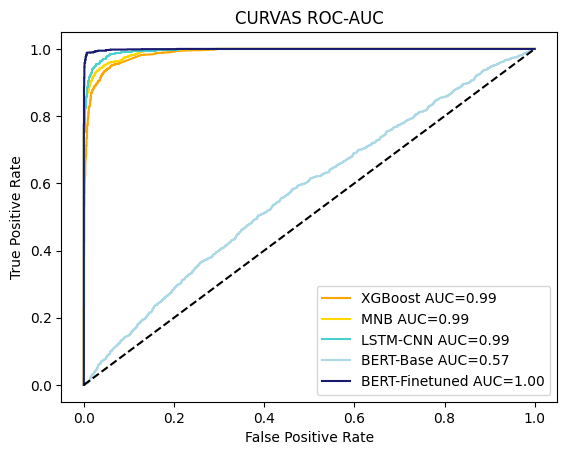

In [ ]:
plot_roc_auc_curve([row[1] for row in models_text_results], ytest_text, text_results)

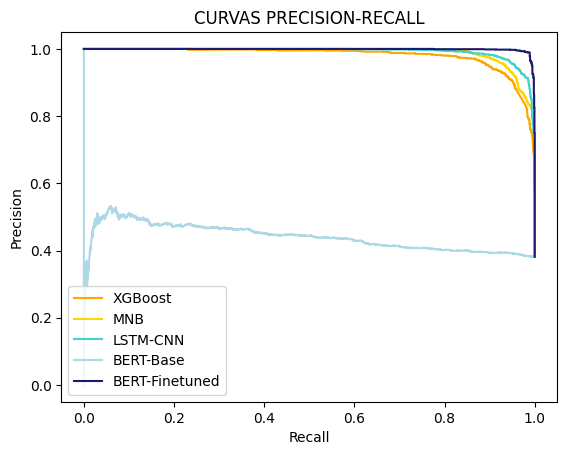

In [ ]:
plot_pre_rec_curve([row[1] for row in models_text_results], ytest_text, text_results)

### URL Classification

In [ ]:
# url models predictions
models_url_results = [xgb_url_results, mnb_url_results, nn_url_results, bert_base_url_results, bert_trained_url_results]

In [ ]:
url_results = pd.DataFrame(
    metrics_evaluation(models_url_results, ytest_url),
    index = ['XGBoost', 'MNB', 'LSTM-CNN', 'BERT-Base', 'BERT-Finetuned']
)

url_results

,accuracy,precision,recall,auc
XGBoost,0.832848,0.901290,0.722898,0.931936
MNB,0.892328,0.922771,0.840880,0.973834
LSTM-CNN,0.532047,1.000000,0.002587,0.501301
BERT-Base,0.469167,0.469160,0.999741,0.560019
BERT-Finetuned,0.976815,0.985979,0.964295,0.996684


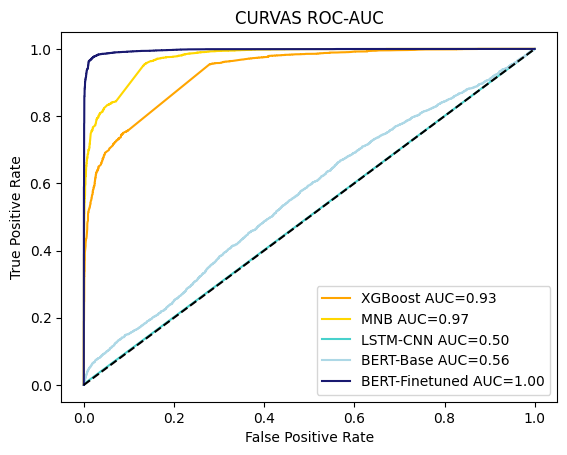

In [ ]:
plot_roc_auc_curve([row[1] for row in models_url_results], ytest_url, url_results)

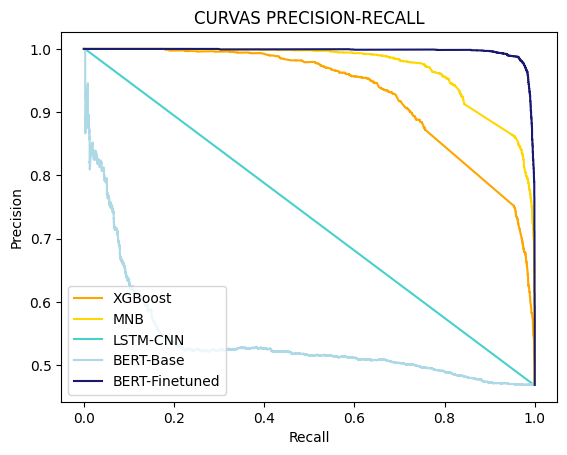

In [ ]:
plot_pre_rec_curve([row[1] for row in models_url_results], ytest_url, url_results)

### Website Classification

In [28]:
# web models predictions
models_web_results = [xgb_web_results, mnb_web_results, nn_web_results, bert_base_web_results, bert_trained_web_results]

In [29]:
web_results = pd.DataFrame(
    metrics_evaluation(models_web_results, ytest_web),
    index = ['XGBoost', 'MNB', 'LSTM-CNN', 'BERT-Base', 'BERT-Finetuned']
)

web_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,auc
XGBoost,0.950190,0.933702,0.922657,0.987634
MNB,0.925127,0.891206,0.894449,0.973639
LSTM-CNN,0.927030,0.895359,0.895359,0.977547
BERT-Base,0.353426,0.333096,0.852593,0.420363
BERT-Finetuned,0.651332,0.000000,0.000000,0.472512


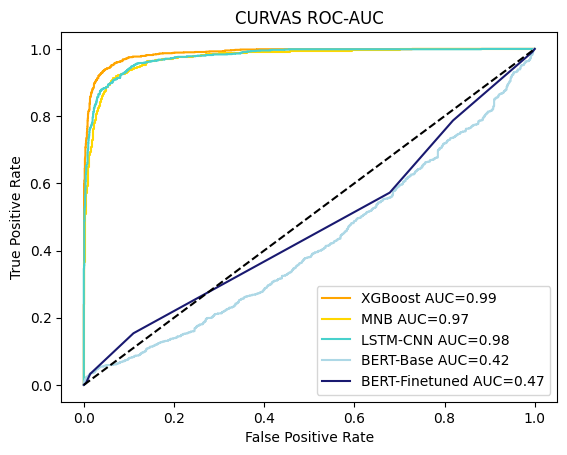

In [30]:
plot_roc_auc_curve([row[1] for row in models_web_results], ytest_web, web_results)

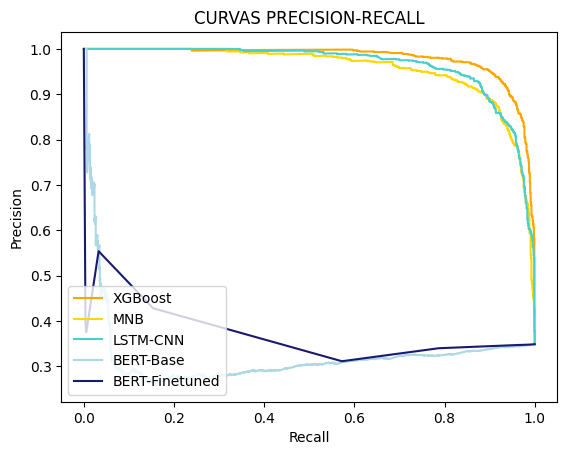

In [31]:
plot_pre_rec_curve([row[1] for row in models_web_results], ytest_web, web_results)

### Combined Phishing Dataset Classification

In [ ]:
# combined dataset models predictions
models_comb_results = [xgb_comb_results, mnb_comb_results, nn_comb_results, bert_base_comb_results, bert_tuned_comb_results]

In [ ]:
comb_results = pd.DataFrame(
    metrics_evaluation(models_comb_results, ytest_comb),
    index = ['XGBoost', 'MNB', 'LSTM-CNN', 'BERT-Base', 'BERT-Finetuned']
)

comb_results

,accuracy,precision,recall,auc
XGBoost,0.850036,0.919944,0.705602,0.942189
MNB,0.875008,0.891957,0.800400,0.957777
LSTM-CNN,0.724979,0.935907,0.373038,0.825239
BERT-Base,0.579425,0.718750,0.003540,0.587870
BERT-Finetuned,0.984433,0.984215,0.978763,0.996928


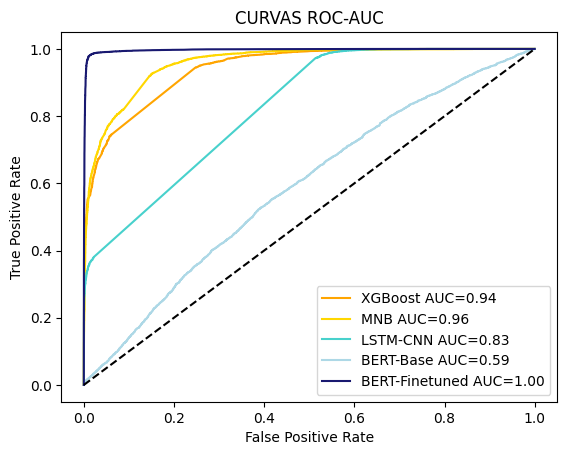

In [ ]:
plot_roc_auc_curve([row[1] for row in models_comb_results], ytest_comb, comb_results)

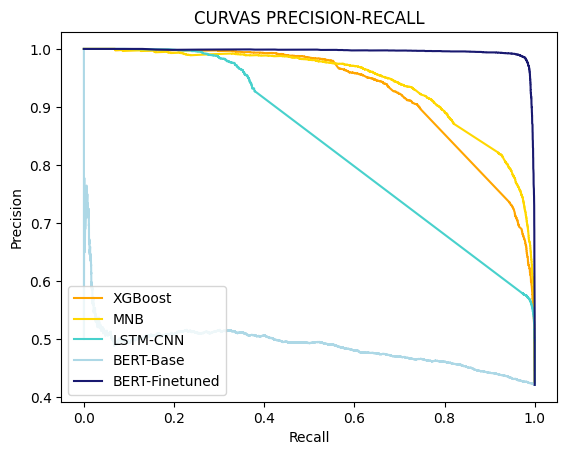

In [ ]:
plot_pre_rec_curve([row[1] for row in models_comb_results], ytest_comb, comb_results)